In [10]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [11]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1100889, 20)
         frame_index  res_event_index  res_event_duration
0                  0              0.0                 0.0
1                  1              1.0                96.0
2                  2              1.0                96.0
3                  3              1.0                96.0
4                  4              1.0                96.0
...              ...              ...                 ...
1100884      1100884          32264.0               158.0
1100885      1100885          32264.0               158.0
1100886      1100886          32264.0               158.0
1100887      1100887          32264.0               158.0
1100888      1100888          32264.0               158.0

[1100889 rows x 3 columns]
12021.0
1.0
918417
918417
[4.56434819 4.56434819 4.56434819 ... 5.06259503 5.06259503 5.06259503]
[12021  7432  5990  4327  3629  3253  2877  2839  2397  2233  2032  2003
  1990  1840  1805  1700  1621  1620  1603  1580]


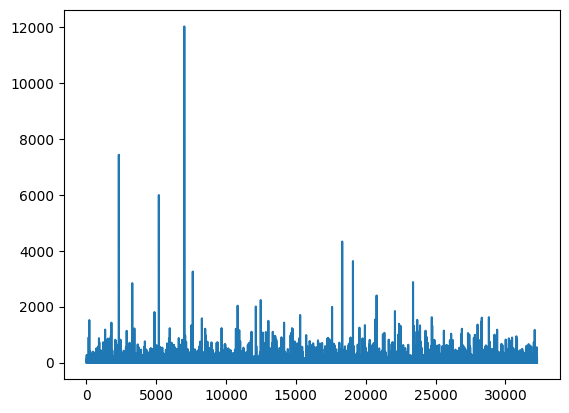

In [17]:
dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

events_all = combined_residence_events(dmat)
# mapping = np.zeros(len(events_all))
# avg = np.zeros([len(events_all), len(dmat[0,:])])
# print(avg.shape)
# print(len(events_all))
# print(len(mapping))


# count = 0
# for event in events_all:
#   mapping[count] = len(event)
#   avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
#   count += 1
  
  
mapping = np.zeros(len(dmat[:,0]))
event_index = np.zeros(len(dmat[:,0]))
frame_index = np.arange(len(dmat[:,0]))

count = 0
for event in events_all:
  count += 1
  for i in range(len(event)):
    mapping[event[i]] = len(event)
    event_index[event[i]] = count

dataset_meta = pd.DataFrame({'frame_index': frame_index, 'res_event_index': event_index, 'res_event_duration': mapping})

print(dataset_meta)

todrop = dataset_meta[dataset_meta['res_event_duration'] == 0].index

dmat = np.delete(dmat, todrop, axis=0)
mapping = np.delete(mapping, todrop, axis=0)
logmapping = np.log(mapping)

print(np.max(mapping))
print(np.min(mapping))

print(len(mapping))
print(len(dmat))
print(logmapping)

dmean = np.mean(dmat, 0)
dstd = np.std(dmat, 0)

dmat = (dmat - dmean)/dstd



plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])

# plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])
plt.plot(ploteventsintime)

In [18]:
N = len(logmapping)
test_low = 0
test_high = int(0.25*N)
while(logmapping[test_high] == logmapping[test_high-1]):
  test_high = test_high + 1
print("test frame range", test_low, "to", test_high)
train_low = test_high + 1
train_high = int(0.9*N)
while(logmapping[train_high] == logmapping[train_high-1]):
  train_high = train_high + 1
print("val frame range", train_low, "to", train_high)
val_low = train_high + 1
val_high = len(logmapping) - 1
print("val frame range", val_low, "to", val_high)

test frame range 0 to 229916
val frame range 229917 to 826764
val frame range 826765 to 918416


In [19]:
inputs = torch.from_numpy(dmat)
inputs = torch.tensor(inputs, dtype=torch.float32)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
dataset = TensorDataset(inputs, targets)

N = len(dataset)
indices = np.arange(N)
# indices = np.random.permutation(indices)
test_indices = indices[test_low:test_high]
val_indices = indices[val_low:val_high]
train_indices = indices[train_low:train_high]

print("train indices:")
print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print("val indices:")
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print("test indices:")
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

train indices:
596847
[229917 229918 229919 ... 826761 826762 826763]
val indices:
91651
[826765 826766 826767 ... 918413 918414 918415]
test indices:
229916
[     0      1      2 ... 229913 229914 229915]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78775/3493379150.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78775/3493379150.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [21]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            print()
        print()
        
    return model, all_preds, all_labels

In [23]:
trained_model, ap, al = train_model(model, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.2562

val Loss: 1.1544


Epoch 1/4
----------
train Loss: 1.2355

val Loss: 1.1816


Epoch 2/4
----------
train Loss: 1.2242

val Loss: 1.2149


Epoch 3/4
----------
train Loss: 1.2145

val Loss: 1.1821


Epoch 4/4
----------
train Loss: 1.2098

val Loss: 1.1948




In [24]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))

al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

tensor(5.1028)
tensor(5.0482)
tensor(277.5190)
tensor(330.0397)


In [25]:
top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])

predicted [[2602.5955]] real: [422.]
predicted [[2574.208]] real: [997.9999]
predicted [[2514.5347]] real: [997.9999]
predicted [[2429.1895]] real: [997.9999]
predicted [[2389.964]] real: [422.]
predicted [[2368.678]] real: [536.9999]
predicted [[2287.9492]] real: [162.99997]
predicted [[2264.0203]] real: [997.9999]
predicted [[2227.3271]] real: [259.]
predicted [[2217.4675]] real: [822.00006]
predicted [[2172.4626]] real: [536.9999]
predicted [[2161.3757]] real: [862.99994]
predicted [[2134.9607]] real: [205.99998]
predicted [[2123.1133]] real: [997.9999]
predicted [[2096.34]] real: [997.9999]
predicted [[2068.9827]] real: [728.]
predicted [[2049.2065]] real: [862.99994]
predicted [[2009.968]] real: [862.99994]
predicted [[2007.4939]] real: [822.00006]
predicted [[1975.1138]] real: [422.]


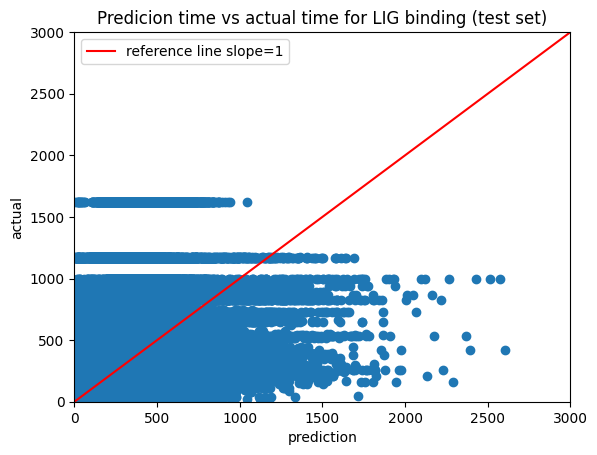

In [29]:
plt.scatter(ap,al)
x = np.linspace(0, 3000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,3000])
plt.xlim([0,3000])
plt.show()

/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78775/3748498033.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,3000])
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78775/3748498033.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,3000])


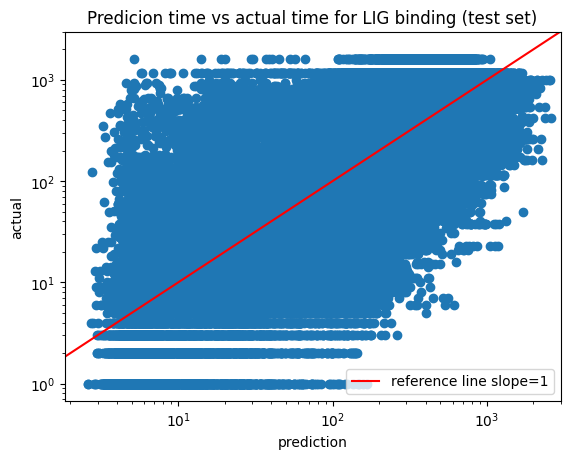

In [30]:
plt.scatter(ap,al)
plt.xscale("log")
plt.yscale("log")
x = np.linspace(0, 3000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,3000])
plt.xlim([0,3000])
plt.show()

In [31]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [32]:
ap2, al2 = test_model(trained_model)

Test Loss: 1.7831


In [33]:
print(torch.mean(ap2))
print(torch.mean(al2))

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

tensor(5.3093, grad_fn=<MeanBackward0>)
tensor(5.5601)
tensor(368.3479, grad_fn=<MeanBackward0>)
tensor(1354.4067)


In [34]:
top = (-ap2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[5026.7007]] real: [[1516.]]
predicted [[4969.436]] real: [[1516.]]
predicted [[4646.0176]] real: [[1516.]]
predicted [[4373.5503]] real: [[1516.]]
predicted [[4207.647]] real: [[1516.]]
predicted [[4171.528]] real: [[725.]]
predicted [[4153.8345]] real: [[1516.]]
predicted [[4118.1533]] real: [[1516.]]
predicted [[3903.845]] real: [[1516.]]
predicted [[3892.614]] real: [[1516.]]
predicted [[3869.9165]] real: [[1516.]]
predicted [[3839.0793]] real: [[1516.]]
predicted [[3779.7437]] real: [[1516.]]
predicted [[3771.2966]] real: [[1516.]]
predicted [[3755.376]] real: [[1516.]]
predicted [[3733.5144]] real: [[1516.]]
predicted [[3730.6458]] real: [[1516.]]
predicted [[3699.5315]] real: [[1516.]]
predicted [[3667.337]] real: [[1516.]]
predicted [[3661.745]] real: [[1516.]]


In [35]:
bottom = (ap2).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[2.4781733]] real: [[1.]]
predicted [[2.5705502]] real: [[3.]]
predicted [[2.713959]] real: [[6.]]
predicted [[2.7276938]] real: [[2.]]
predicted [[2.756157]] real: [[1.]]
predicted [[2.8170743]] real: [[3.]]
predicted [[2.8260422]] real: [[8.]]
predicted [[2.8411415]] real: [[5.]]
predicted [[2.8510976]] real: [[1.]]
predicted [[2.868341]] real: [[2.]]
predicted [[2.909425]] real: [[1.]]
predicted [[2.9179509]] real: [[3.]]
predicted [[2.9308376]] real: [[32.]]
predicted [[2.9355526]] real: [[5.]]
predicted [[2.9425697]] real: [[2.]]
predicted [[2.9471214]] real: [[1.]]
predicted [[2.971596]] real: [[1.]]
predicted [[2.9720502]] real: [[1.]]
predicted [[2.9838154]] real: [[1.]]
predicted [[2.998155]] real: [[2.]]


[12020.996   7432.0005  5989.998   2839.      1804.9999  1516.
  1426.      1227.9999  1219.0002  1176.9999]
12021


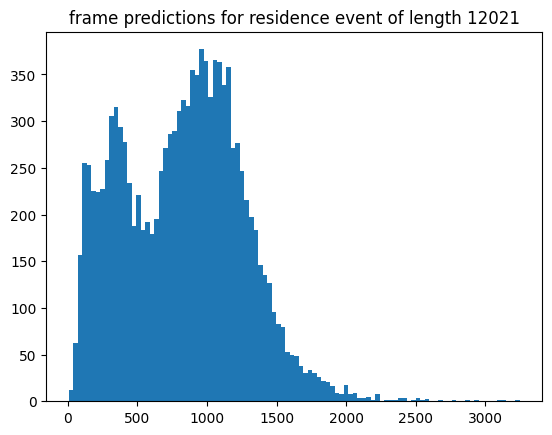

7432


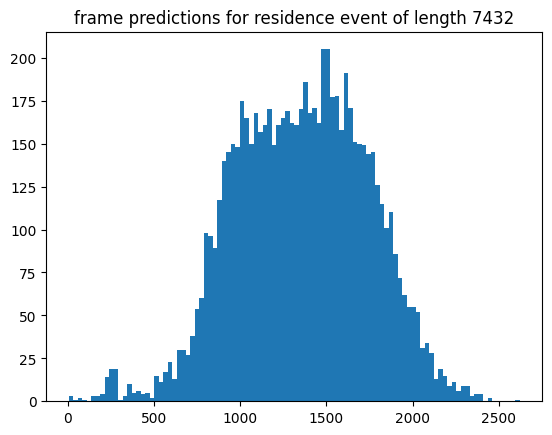

5990


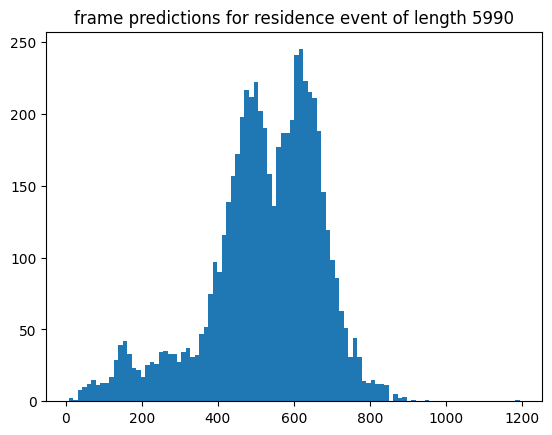

2839


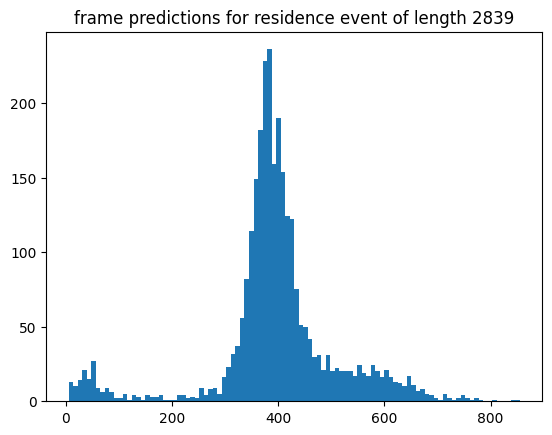

1805


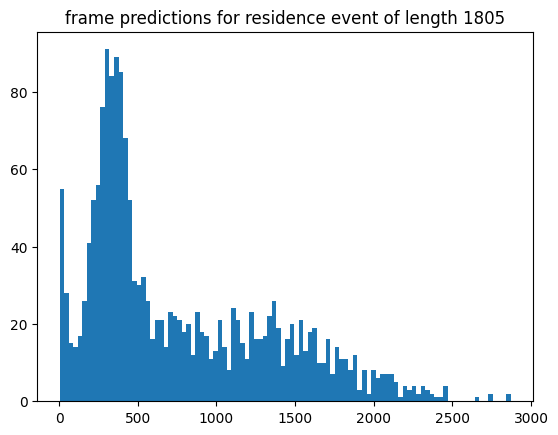

1516


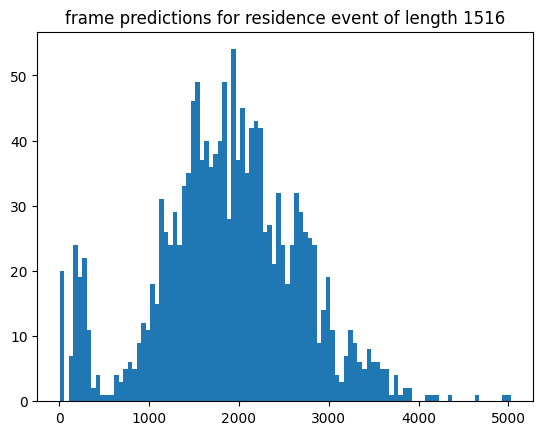

1426


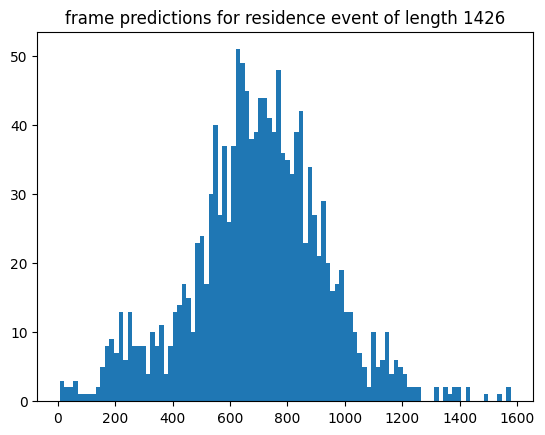

1228


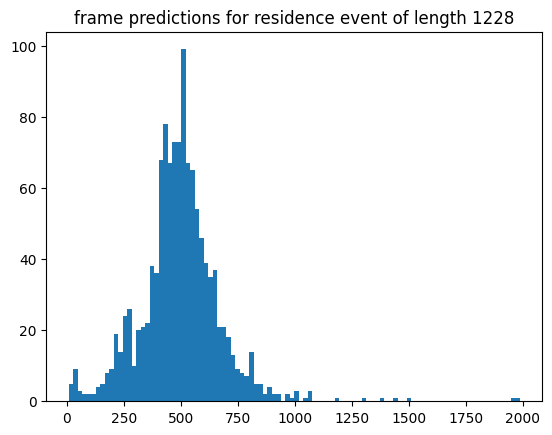

1219


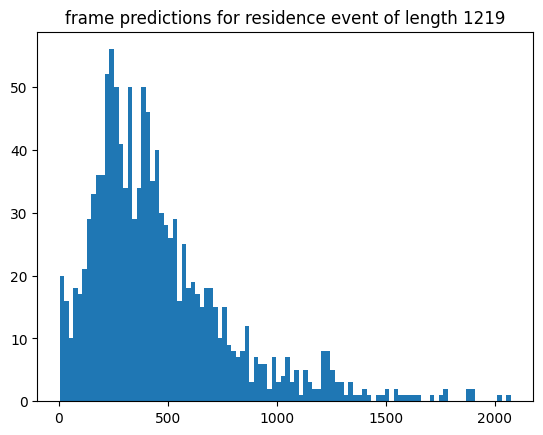

1177


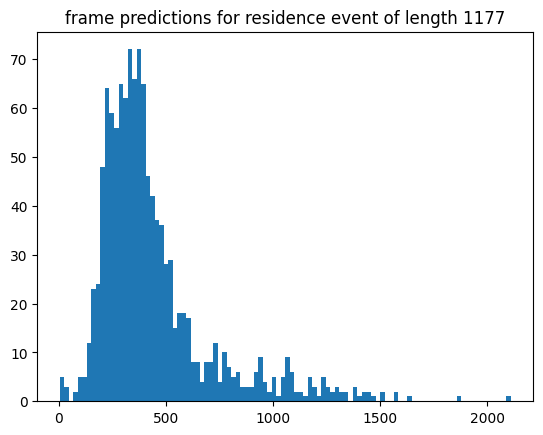

<Figure size 640x480 with 0 Axes>

In [36]:
print(np.sort(np.unique(al2))[::-1][:10])
top_ten = np.sort(np.unique(al2))[::-1][:10]

for i in range(10):
  index = np.where(al2 == top_ten[i])[0]
  preds = ap2[index]
  print(len(preds))

  plt.hist(preds, bins=100)
  plt.title("frame predictions for residence event of length " + str(len(preds)))
  plt.show()
  plt.clf()

r2: 0.504739274168893


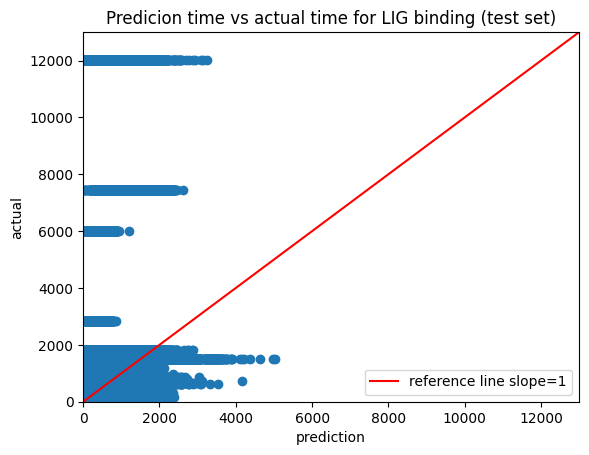

In [40]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 13000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,13000])
plt.xlim([0,13000])
plt.show()

r2: 0.504739274168893


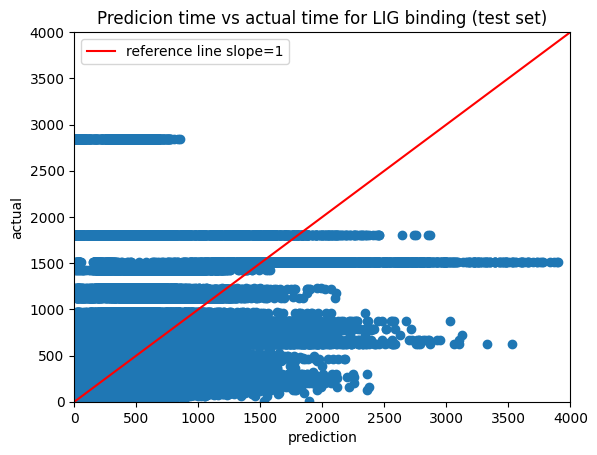

In [41]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 4000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,4000])
plt.xlim([0,4000])
plt.show()

r2: 0.504739274168893


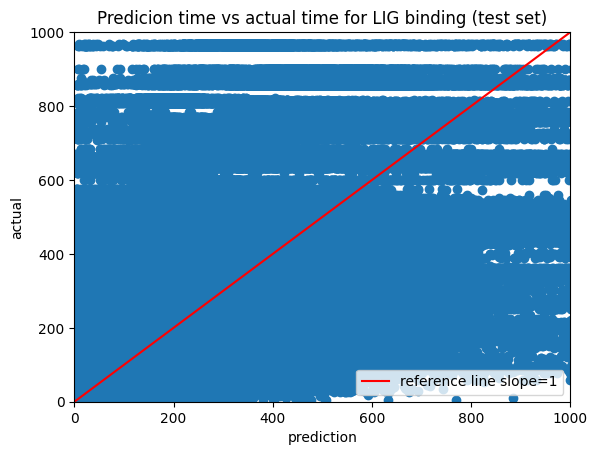

In [42]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 1000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,1000])
plt.xlim([0,1000])
plt.show()

r2: 0.504739274168893


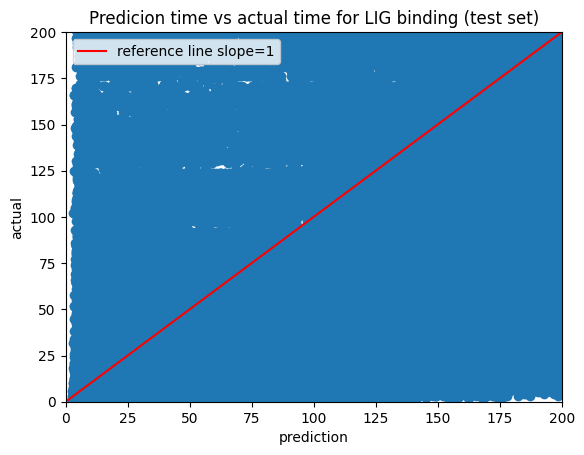

In [43]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

x = np.linspace(0, 1000,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.ylim([0,200])
plt.xlim([0,200])
plt.show()

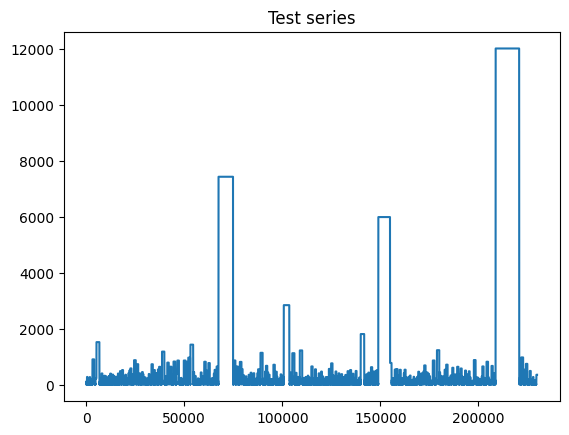

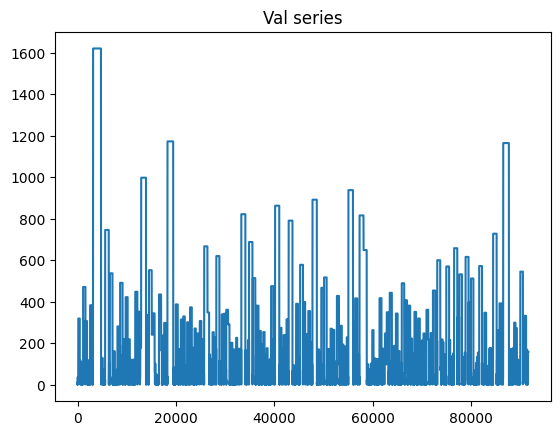

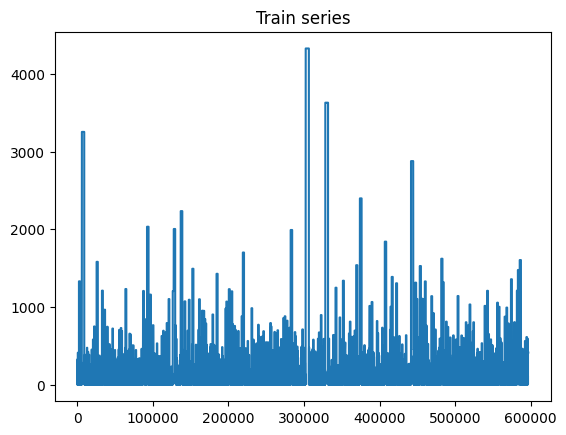

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(mapping[test_low:test_high])
plt.title("Test series")
plt.show()
plt.clf()
plt.plot(mapping[val_low:val_high])
plt.title("Val series")
plt.show()
plt.clf()
plt.plot(mapping[train_low:train_high])
plt.title("Train series")
plt.show()
plt.clf()